In [23]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import xgboost as xgb
import numpy as np

In [3]:
import os
path = os.path.dirname(xgb.__file__)
print(path)

/home/agavrilenko/anaconda3/lib/python3.6/site-packages/xgboost


In [4]:
#help(xgboost.training.train)
help(xgb.train)

Help on function train in module xgboost.training:

train(params, dtrain, num_boost_round=10, evals=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, learning_rates=None)
    Train a booster with given parameters.
    
    Parameters
    ----------
    params : dict
        Booster params.
    dtrain : DMatrix
        Data to be trained.
    num_boost_round: int
        Number of boosting iterations.
    evals: list of pairs (DMatrix, string)
        List of items to be evaluated during training, this allows user to watch
        performance on the validation set.
    obj : function
        Customized objective function.
    feval : function
        Customized evaluation function.
    maximize : bool
        Whether to maximize feval.
    early_stopping_rounds: int
        Activates early stopping. Validation error needs to decrease at least
        every **early_stopping_rounds** round(s) to cont

In [14]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler # Preprocessing
from sklearn.linear_model import Lasso, Ridge, ElasticNet, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge # Linear models
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  # Ensemble methods
from xgboost import XGBRegressor, plot_importance # XGBoost
from sklearn.svm import SVR, SVC, LinearSVC  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline # Streaming pipelines
from sklearn.decomposition import KernelPCA, PCA # Dimensionality reduction
from sklearn.feature_selection import SelectFromModel # Dimensionality reduction
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV # Model evaluation
from sklearn.base import clone # Clone estimator
from sklearn.metrics import mean_squared_error as MSE
import xgboost as xgb

In [15]:
# load data
import pandas as pd
df_usa = pd.read_csv('data/houses/housesalesprediction/kc_house_data.csv', delimiter=",")

dataset.head()


df_usa.drop(['id', 'date'], axis=1, inplace=True)
X = df_usa.drop("price",axis=1).values
y = df_usa["price"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=3)

# split data into X and y
# X = dataset[:,0:8]
# Y = dataset[:,8]
# # split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=6)

In [75]:
dtrain = xgb.DMatrix(data = X_train, label = y_train, silent= True)

deval = xgb.DMatrix(data = X_test, label = y_test, silent= True)
# evals_list = []
# evals_list.append((deval, "eval matrix"))
num_epochs = 600
params = {}
params['num_boost_round'] = num_epochs
params['early_stopping_rounds'] = 1000
#params['verbose_eval'] = 1
params['eval_metric'] = 'rmse'
params['evals_result'] = {}
params['max_depth'] = 3




In [103]:
learning_rates = []
tresholds = []
learning_rates.append(0.1)
counter = 0
best = []
progress = dict()
wait = []
def reduceLRonPlateau(i,n):

    factor = 0.5
    min_lr = 1e-30
    min_delta = 1000
    patience = 10
    verbose = 0
    cooldown = 3
    cooldown_counter = 0  # Cooldown counter.
    
    #best = 0
    mode = 'min'  
    monitor_op = None
    old_lr = learning_rates[0]
    new_lr = learning_rates[0] 
    
    def in_cooldown():
            return cooldown_counter > 0
    
    def _reset(mode):
        """Resets wait counter and cooldown counter."""
#         if mode not in ['auto', 'min', 'max']:
#             warnings.warn('Learning Rate Plateau Reducing mode %s is unknown, '
#                           'fallback to auto mode.' % (mode),
#                           RuntimeWarning)
#             mode = 'auto'
#         if (mode == 'min' or
#            (mode == 'auto' and 'acc' not in monitor)):
#             monitor_op = lambda a, b: np.less(a, b - min_delta)
#             best = np.Inf
#         else:
#             monitor_op = lambda a, b: np.greater(a, b + min_delta)
#             best = -np.Inf
            
        cooldown_counter = 0
        del wait[:]
        return wait, cooldown_counter
    
    def checker(wait,best, new_lr, learning_rates):
        if (i == 0):
            wait, counter = _reset(mode)
            print("initialization...")
            print("lr: ", learning_rates[0])
            best.append(100000000)
            
        if (i>0):
            old_lr = learning_rates[i-1]
            #new_lr = learning_rates[i-1]
            current = progress['eval']['rmse'][i-1]
            if in_cooldown():
                cooldown_counter -= 1
                del wait[:]
              
            print("iter: ", i, " Current_loss: ", current, "best: ", best[i-1])
            if np.less(current, best[i-1] - min_delta):
                best.append(current)
                del wait[:]
             
            elif not in_cooldown():
                #rint("not in_cooldown")
                best.append(best[-1])
                wait.append(1)
                if len(wait) >= patience:
                    
                    if old_lr > min_lr:
                        new_lr = old_lr * factor
                        new_lr = max(new_lr, min_lr)
                        print("iter: ", i, "reducing lr -- ", " old_lr: ", old_lr, " new_lr: ", new_lr)
                        
#                         if self.verbose > 0:
#                             print('\nEpoch %05d: ReduceLROnPlateau reducing '
#                                   'learning rate to %s.' % (epoch + 1, new_lr))
                        cooldown_counter = cooldown
                        del wait[:]
        return new_lr


       # print("step ",progress['train']['logloss'][i-1], "i = ", i)

            
    
    new_lr = checker(wait,best,new_lr,learning_rates)
    learning_rates.append(new_lr)
        
    return new_lr

In [104]:

def run_gbm(dtrain, dvalid, param, evals_result, learning_rate):
    # check training arguments in param
    n_round = param.get('num_boost_round', 100)
    early_stop = param.get('early_stopping_rounds', 0)
    verbose_eval = param.get('verbose_eval', 50)
    # specify validations set to watch performance
    watchlist = [(dtrain,'train') ,(deval,'eval')]
    #callbacks_list = [learning_rates]

    bst = xgb.train(params=param,
            dtrain=dtrain,
            num_boost_round=n_round,
            evals=watchlist,
            early_stopping_rounds=early_stop,
            verbose_eval = verbose_eval,
            evals_result = evals_result, 
            callbacks = [xgb.callback.reset_learning_rate(reduceLRonPlateau)])
                   
    return bst 

In [105]:
model1 = run_gbm(dtrain, deval, params,progress, learning_rate = 0.1)

initialization...
lr:  0.1
[0]	train-rmse:597658	eval-rmse:590266
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 1000 rounds.
iter:  1  Current_loss:  590265.5 best:  100000000
iter:  2  Current_loss:  539130.9375 best:  590265.5
iter:  3  Current_loss:  493740.15625 best:  539130.9375
iter:  4  Current_loss:  453324.34375 best:  493740.15625
iter:  5  Current_loss:  417079.59375 best:  453324.34375
iter:  6  Current_loss:  385368.84375 best:  417079.59375
iter:  7  Current_loss:  357464.09375 best:  385368.84375
iter:  8  Current_loss:  332269.125 best:  357464.09375
iter:  9  Current_loss:  310484.65625 best:  332269.125
iter:  10  Current_loss:  290920.0 best:  310484.65625
iter:  11  Current_loss:  273306.21875 best:  290920.0
iter:  12  Current_loss:  258614.453125 best:  273306.21875
iter:  13  Current_loss:  245829.46875 best:  258614.453125
iter:  14  Current_loss:  233888.078125 best:  245829.

iter:  129  Current_loss:  122188.664062 best:  125516.804688
iter:  130  Current_loss:  122062.96875 best:  125516.804688
iter:  131  Current_loss:  121801.53125 best:  125516.804688
iter:  132  Current_loss:  121785.734375 best:  125516.804688
iter:  133  Current_loss:  121844.1875 best:  125516.804688
iter:  134  Current_loss:  121782.195312 best:  125516.804688
iter:  135  Current_loss:  121703.859375 best:  125516.804688
iter:  135 reducing lr --   old_lr:  0.1  new_lr:  0.05
iter:  136  Current_loss:  121693.5 best:  125516.804688
iter:  137  Current_loss:  121655.804688 best:  125516.804688
iter:  138  Current_loss:  121549.171875 best:  125516.804688
iter:  139  Current_loss:  121345.851562 best:  125516.804688
iter:  140  Current_loss:  121284.0625 best:  125516.804688
iter:  141  Current_loss:  121308.84375 best:  125516.804688
iter:  142  Current_loss:  121341.820312 best:  125516.804688
iter:  143  Current_loss:  121200.296875 best:  125516.804688
iter:  144  Current_loss: 

[250]	train-rmse:101218	eval-rmse:116882
iter:  251  Current_loss:  116882.125 best:  120505.195312
iter:  252  Current_loss:  116839.601562 best:  120505.195312
iter:  253  Current_loss:  116743.695312 best:  120505.195312
iter:  254  Current_loss:  116725.875 best:  120505.195312
iter:  255  Current_loss:  116657.882812 best:  120505.195312
iter:  256  Current_loss:  116585.234375 best:  120505.195312
iter:  257  Current_loss:  116570.09375 best:  120505.195312
iter:  258  Current_loss:  116543.007812 best:  120505.195312
iter:  258 reducing lr --   old_lr:  0.1  new_lr:  0.05
iter:  259  Current_loss:  116552.382812 best:  120505.195312
iter:  260  Current_loss:  116534.34375 best:  120505.195312
iter:  261  Current_loss:  116508.320312 best:  120505.195312
iter:  262  Current_loss:  116516.289062 best:  120505.195312
iter:  263  Current_loss:  116492.796875 best:  120505.195312
iter:  264  Current_loss:  116472.625 best:  120505.195312
iter:  265  Current_loss:  116459.546875 best:

iter:  376  Current_loss:  113953.679688 best:  115491.625
iter:  377  Current_loss:  113941.9375 best:  115491.625
iter:  378  Current_loss:  113935.109375 best:  115491.625
iter:  379  Current_loss:  113891.929688 best:  115491.625
iter:  380  Current_loss:  113926.835938 best:  115491.625
iter:  381  Current_loss:  113912.34375 best:  115491.625
iter:  382  Current_loss:  113900.289062 best:  115491.625
iter:  383  Current_loss:  113864.765625 best:  115491.625
iter:  384  Current_loss:  113860.023438 best:  115491.625
iter:  384 reducing lr --   old_lr:  0.1  new_lr:  0.05
iter:  385  Current_loss:  113855.835938 best:  115491.625
iter:  386  Current_loss:  113793.078125 best:  115491.625
iter:  387  Current_loss:  113740.046875 best:  115491.625
iter:  388  Current_loss:  113746.523438 best:  115491.625
iter:  389  Current_loss:  113721.25 best:  115491.625
iter:  390  Current_loss:  113676.78125 best:  115491.625
iter:  391  Current_loss:  113659.34375 best:  115491.625
iter:  39

iter:  503  Current_loss:  111972.726562 best:  115491.625
iter:  504  Current_loss:  111971.117188 best:  115491.625
iter:  504 reducing lr --   old_lr:  0.1  new_lr:  0.05
iter:  505  Current_loss:  111974.375 best:  115491.625
iter:  506  Current_loss:  111925.015625 best:  115491.625
iter:  507  Current_loss:  111921.359375 best:  115491.625
iter:  508  Current_loss:  111908.15625 best:  115491.625
iter:  509  Current_loss:  111883.15625 best:  115491.625
iter:  510  Current_loss:  111858.710938 best:  115491.625
iter:  511  Current_loss:  111826.039062 best:  115491.625
iter:  512  Current_loss:  111800.164062 best:  115491.625
iter:  513  Current_loss:  111800.765625 best:  115491.625
iter:  514  Current_loss:  111789.023438 best:  115491.625
iter:  514 reducing lr --   old_lr:  0.1  new_lr:  0.05
iter:  515  Current_loss:  111783.492188 best:  115491.625
iter:  516  Current_loss:  111785.53125 best:  115491.625
iter:  517  Current_loss:  111777.4375 best:  115491.625
iter:  518 

In [106]:
# fit model no training data
model = XGBRegressor(n_estimators=num_epochs, learning_rate=0.1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "rmse"], eval_set=eval_set, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

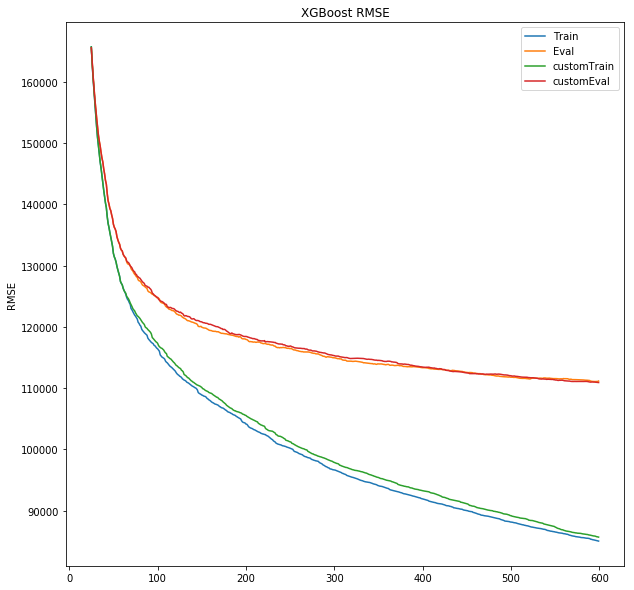

min customEval: 110903.859375
min Eval: 111064.328125


In [107]:
# retrieve performance metrics
results = model.evals_result()
#results1 = model1.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(25, epochs)

# plot log loss
fig, ax = pyplot.subplots(figsize=(10, 10))
ax.plot(x_axis, results['validation_0']['rmse'][25::], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'][25::], label='Eval')
ax.plot(x_axis, progress['train']['rmse'][25::], label = 'customTrain')
ax.plot(x_axis, progress['eval']['rmse'][25::], label = 'customEval')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')

pyplot.show()
print("min customEval:", min(progress['eval']['rmse']))
print("min Eval:", min(results['validation_1']['rmse']))

In [ ]:
# plot classification error
# fig, ax = pyplot.subplots()
# ax.plot(x_axis, results['validation_0']['error'][25::], label='Train')
# ax.plot(x_axis, results['validation_1']['error'][25::], label='Test')
# ax.legend()
# pyplot.ylabel('Classification Error')
# pyplot.title('XGBoost Classification Error')
# pyplot.show()